# Computation of GFM Maximum Flood Extent for a specific area and time of interest

With this notebook we demonstrate how STAC can be used to find GFM
data (ensemble_flood_extent) and derive the maximum flood extent from it.

In [1]:
# Necessary python imports

from pystac_client import Client
from odc import stac as odc_stac
import pyproj
import xarray as xr
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

In [2]:
# Search against the EODC STAC API
catalog = Client.open(
  "https://stac.eodc.eu/api/v1"
)

# Define your area of interest
aoi = {
  "type": "Polygon",
  "coordinates": [
    [
      [16.432800292968754, 50.747318126029434],
      [17.87887573242188, 50.747318126029434],
      [17.87887573242188, 51.306150195330034],
      [16.432800292968754, 51.306150195330034],
      [16.432800292968754, 50.747318126029434]
    ]
  ]
}

# Define your temporal range
daterange = {"interval": ["2024-09-18T00:00:00Z", "2024-09-25T00:00:00Z"]}

# Define your search with CQL2 syntax
search = catalog.search(filter_lang="cql2-json", filter={
  "op": "and",
  "args": [
    {"op": "s_intersects", "args": [{"property": "geometry"}, aoi]},
    {"op": "anyinteracts", "args": [{"property": "datetime"}, daterange]},
    {"op": "=", "args": [{"property": "collection"}, "GFM"]}
  ]
})

# Retrieve all found items
items = search.item_collection()
print("We found", len(items), "items, that match our filter criteria.")

We found 28 items, that match our filter criteria.


In [4]:
# Derive Equi7Grid CRS from first found item
crs = pyproj.CRS.from_wkt(items[0].properties["proj:wkt2"])

# Define assets to load
assets = ["ensemble_flood_extent"]

# Get bounding box from AOI
polygon = Polygon(aoi['coordinates'][0])

# Load asset data into xarray using odc-stac
# Adjust chunk size of x/y according to available RAM
xx = odc_stac.load(
    items, 
    bbox=polygon.bounds,
    crs=crs,
    bands=assets,
    dtype="uint8",
    chunks={"x": 2000, "y": 2000, "time": -1}, 
    resolution=20)
xx.ensemble_flood_extent

<xarray.DataArray 'ensemble_flood_extent' (time: 21, y: 3577, x: 5343)>
dask.array<ensemble_flood_extent, shape=(21, 3577, 5343), dtype=uint8, chunksize=(21, 2000, 2000), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 1.961e+06 1.961e+06 ... 1.889e+06 1.889e+06
  * x            (x) float64 5.304e+06 5.304e+06 ... 5.411e+06 5.411e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2024-09-18T05:25:52 ... 2024-09-23T16:...
Attributes:
    nodata:   255

In [6]:
# Mask data which is nodata (255) and non-flood (0)
xx = xx.where((xx != 255) & (xx != 0))

# Compute sum along time dimension
data = xx.sum(dim="time").astype("uint8")
data.ensemble_flood_extent

<xarray.DataArray 'ensemble_flood_extent' (y: 3577, x: 5343)>
dask.array<astype, shape=(3577, 5343), dtype=uint8, chunksize=(2000, 2000), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 1.961e+06 1.961e+06 ... 1.889e+06 1.889e+06
  * x            (x) float64 5.304e+06 5.304e+06 ... 5.411e+06 5.411e+06
    spatial_ref  int32 0

In [ ]:
# Save result as GeoTiff to disk
import os
import rioxarray
os.makedirs("./maximum_flood_data", exist_ok=True)
data.ensemble_flood_extent.rio.to_raster("./maximum_flood_data/result_equi7.tif", compress="LZW")

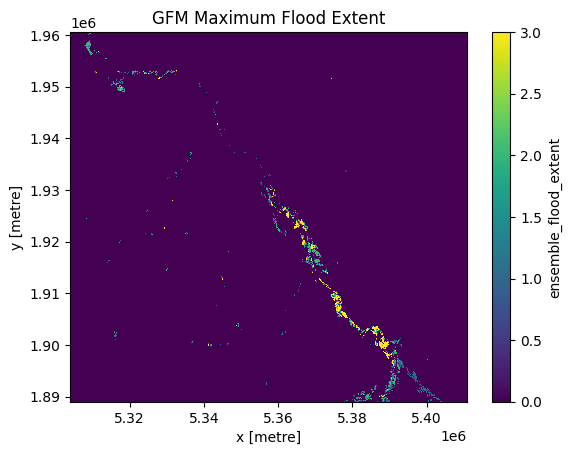

In [7]:
data.ensemble_flood_extent.plot()
plt.title("GFM Maximum Flood Extent")
plt.show()